In [1]:
import json
import os
import numpy as np

from PIL import Image, ImageDraw
import scipy.ndimage.morphology as morph

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

data_path = "/storage/ProtopopovI/_data_/ytb_vos/train/JPEGImages/"

In [2]:
with open('/storage/ProtopopovI/_project_/SiamRUNet/test.json') as data_file:
    data_json = json.load(data_file)

In [3]:
data_json[0].keys()

dict_keys(['person_id', 'video_id', 'file_name', 'width', 'height', 'center', 'bbox', 'segmentation', 'target_info'])

In [4]:
class YtbVosData(Dataset):
    def __init__(self):
        super().__init__()
        self.json = data_json
        self.data_path = "/storage/ProtopopovI/_data_/ytb_vos/train/JPEGImages/"
        
        self.target_trans = transforms.Compose([
            transforms.Resize((128, 128), interpolation=0),
            transforms.ToTensor()
            ])
        self.search_trans = transforms.Compose([
            transforms.Resize((256, 256), interpolation=0),
            transforms.ToTensor()
            ])
        
    def Rle_to_numpy(self, RLE, width, height):
        NOT_RLE = []
        for i, data in enumerate(RLE):
            if i % 2 == 0:
                x = 0
            else:
                x = 1
            for j in range(data):
                NOT_RLE.append(x)
        np_array = np.asarray(NOT_RLE)
        np_array = np_array.reshape(width, height).T#.tolist()
        np_array = np.uint8(np_array*255)
        #np_array = np.expand_dims(np_array, axis=0)
        return np_array
    
    def resize_bbox(self, center, bbox, width, height):
        raise
        
    def transform_score_label(self, depth2):
        depth2 = depth2.reshape(1, 1, depth2.size(0), depth2.size(1))
        max_value = depth2.max()
        depth2 = (depth2 == max_value).float()
        score_label = F.max_pool2d(depth2, kernel_size=(16, 16), padding=8, stride=16)
        score_zero = (score_label == 0).float()
        score_label = torch.stack([score_zero, score_label], dim=1).squeeze()
        return score_label

    def get_labels(self, object):
        labels = torch.tensor([])
        depths = torch.tensor([])
        score_labels = torch.tensor([])
        label1 = (object==0).float()
        depth1 = torch.tensor(morph.distance_transform_edt(np.asarray(label1[0])))
        label2 = (label1==0).float()
        depth2 = torch.tensor(morph.distance_transform_edt(np.asarray(label2[0])))
        depth = (depth1 + depth2).float().unsqueeze(0)
        label = torch.stack([label1, label2], dim=1)
        labels = torch.cat([labels, label], dim=0)
        depths = torch.cat([depths, depth], dim=0)
        score_label = self.transform_score_label(depth2).unsqueeze(0)
        score_labels = torch.cat([score_labels, score_label], dim=0)
        labels = labels.squeeze()
        score_labels = score_labels.squeeze()
        return labels, depths, score_labels

    def Choise_feat(self, label, score_label, x=8):
        score_label = score_label[0][1]
        max_value = score_label.max()
        pos = (score_label == max_value).nonzero()#.unsqueeze(0)

        label = label.permute(0, 2, 3, 1)
        i_tensors = torch.tensor([])
        for i in range(label.size(0)):
            i_tensor = label[i][x*pos[i][0]:x*pos[i][0]+x*16, x*pos[i][1]:x*pos[i][1]+x*16, :].unsqueeze(0)
            i_tensors = torch.cat([i_tensors, i_tensor], dim=0)

        label = i_tensors.permute(0, 3, 1, 2)
        return label
    
    def __len__(self):
        return len(self.json)
    
    def  __getitem__(self, idx):
        search_name = self.json[idx]['file_name']
        target_name = self.json[idx]['target_info']['target_name']
        RLE_search = data_json[idx]['segmentation']
        width = data_json[0]['width']
        height = data_json[0]['height']
        search = Image.open(self.data_path + search_name).convert('RGB')
        seg_search = self.Rle_to_numpy(RLE_search, width, height)
        mask_search = Image.fromarray(seg_search)
        target = Image.open(self.data_path + search_name).convert('RGB')
        
        
        
        
        return search, mask_search, search_name, target, target_name

In [5]:
data_json[0]['target_info'].keys()

dict_keys(['target_name', 'target_bbox', 'target_center', 'target_segmentation'])

In [13]:
data = YtbVosData()
def show(idx):
    search, mask, search_name, target, target_name = data[idx]
    print('search: 0, mask: 1')
    inp = int(input())
    if inp == 0:
        out = search
    elif inp == 1:
        out = mask
    elif inp == 2:
        out = target
    print('search_name: ', search_name)
    print('target_name: ', target_name)
    return out

search: 0, mask: 1
0
search_name:  07913cdda7/00035.jpg
target_name:  07913cdda7/00000.jpg


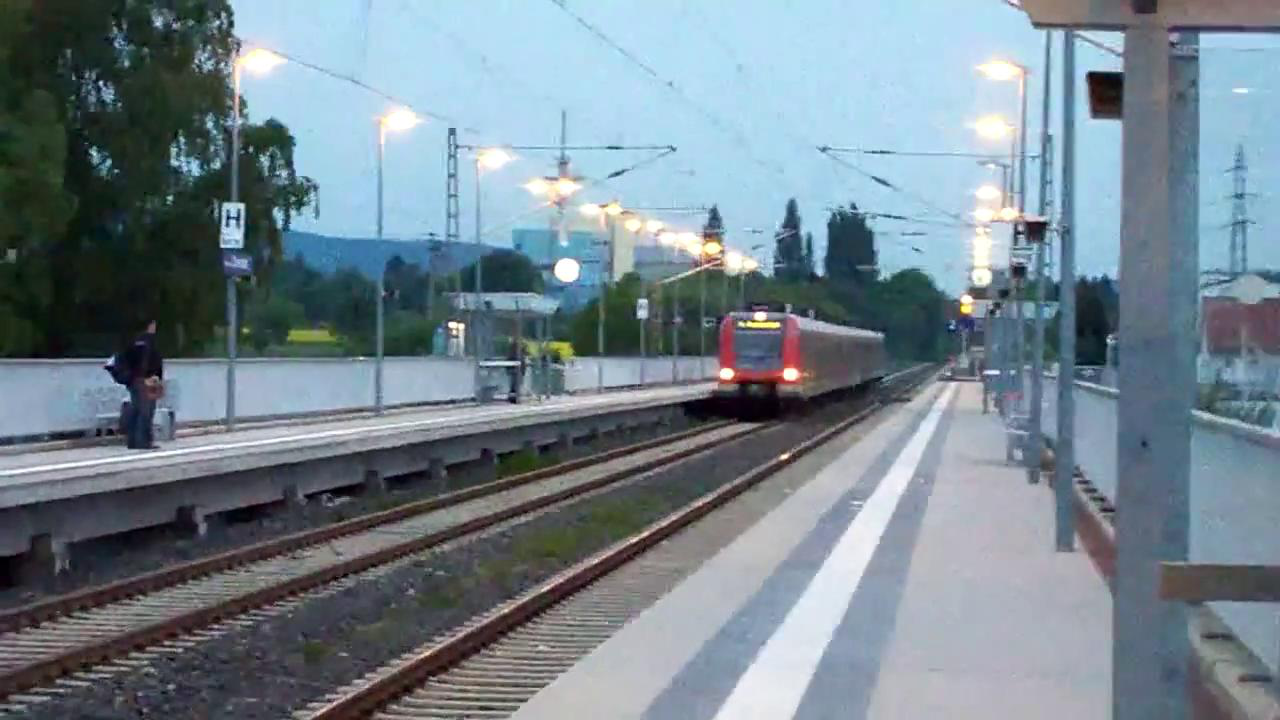

In [16]:
show(559)

In [8]:
seg = Rle_to_numpy(data_json[0]['segmentation'], data_json[0]['width'], data_json[0]['height'])

NameError: name 'Rle_to_numpy' is not defined

In [ ]:
type(seg)
seg.shape

In [ ]:
im = Image.fromarray(seg)

In [ ]:
im

In [ ]:
Image.open("/storage/ProtopopovI/_data_/ytb_vos/train/JPEGImages/"+'01c4cb5ffe/00045.jpg')